In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

#from model.unet.unet_model import UNet
#from model.segnet.segnet_model import SegNet
#from torchvision.models.segmentation import deeplabv3_resnet101 as DeepLabv3
from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50

#Image_Size = [384, 1242]
Image_Size = [384, 1216]
#Image_Size = [384,384]
Gradient_Clipping = 0.8

#Num_Class = 31
#Num_Class = 21
Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'unet'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = False
checkpoint_dir = '../trained'
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)

dir_checkpoint = Path(checkpoint_dir)

train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.RandomGamma(p=0.5),
        #A.RandomSnow(p=0.5),
        #A.RandomRain(p=0.5),
        #A.RandomFog(p=0.5),
        #A.RandomSunFlare(p=0.5),
        A.RandomShadow(p=0.5),
        #A.RandomToneCurve(p=0.5),
        #A.GaussNoise(p=0.5),
        #A.Emboss(p=0.5),  # IAAEmboss 대신 Emboss 사용
        #A.Perspective(p=0.5),  # IAAPerspective 대신 Perspective 사용
        #A.CLAHE(p=0.5)
])

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
#datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent, train_transform)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 826.52it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    voting_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    
else:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score

grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss


def forward_and_backward(model, images, true_masks, amp, optimizer, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']

        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels


        if model_name == 'ensemble_voting':
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
        else:
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)

    
    optimizer.zero_grad(set_to_none=True)
    if model_name == 'ensemble_voting':
        for pred, loss in zip([unet_pred, segnet_pred, enet_pred], [unet_loss, segnet_loss, enet_loss]):
            grad_scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
            grad_scaler.step(optimizer)
            grad_scaler.update()
        
        return model, unet_loss, segnet_loss, enet_loss
    else:
        optimizer.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
        grad_scaler.step(optimizer)
        grad_scaler.update()
        
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optimizer, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score)
                TrainLoss_list1.append(unet_loss)
                valScore_list2.append(segnet_val_score)
                TrainLoss_list2.append(segnet_loss)                
                valScore_list3.append(enet_val_score)
                TrainLoss_list3.append(enet_loss)
                valScore_list4.append(voting_val_score)
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                
                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

                #valScore_list.append(val_score)
                #TrainLoss_list.append(loss)
                #print('Validation Dice score: {}'.format(val_score))
                                
        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:08<00:00, 44.12img/s]

***
unet Loss: 0.6181782484054565


Epoch 1/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.50img/s]


---
unet Validation Dice Loss: 1.3248586654663086
unet Validation Pixel Accuracy: 0.4451144034402412
unet Validation MIoU: 0.27932969290819276
unet Validation Dice Score: 0.3757688105106354


Epoch 2/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.86img/s]

***
unet Loss: 0.4558774530887604


Epoch 2/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.59img/s]


---
unet Validation Dice Loss: 0.6694188117980957
unet Validation Pixel Accuracy: 0.92198127612733
unet Validation MIoU: 0.7707237968689284
unet Validation Dice Score: 0.7611369490623474


Epoch 3/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.78img/s]

***
unet Loss: 0.4365500807762146


Epoch 3/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.48img/s]


---
unet Validation Dice Loss: 0.6603415012359619
unet Validation Pixel Accuracy: 0.9060505649499726
unet Validation MIoU: 0.7476796977631056
unet Validation Dice Score: 0.7790752053260803


Epoch 4/50:  99%|█████████▊| 200/203 [00:06<00:00, 44.04img/s]

***
unet Loss: 0.40059351921081543


Epoch 4/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.70img/s]


---
unet Validation Dice Loss: 0.5011804103851318
unet Validation Pixel Accuracy: 0.9425150553385416
unet Validation MIoU: 0.8202065987591034
unet Validation Dice Score: 0.8089799284934998


Epoch 5/50:  99%|█████████▊| 200/203 [00:06<00:00, 44.02img/s]

***
unet Loss: 0.34483641386032104


Epoch 5/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.03img/s]


---
unet Validation Dice Loss: 0.4901584982872009
unet Validation Pixel Accuracy: 0.9336515727796053
unet Validation MIoU: 0.7939285044290315
unet Validation Dice Score: 0.8192826509475708


Epoch 6/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.82img/s]

***
unet Loss: 0.405994713306427


Epoch 6/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.43img/s]


---
unet Validation Dice Loss: 0.4333947002887726
unet Validation Pixel Accuracy: 0.9415823953193531
unet Validation MIoU: 0.8206630079738619
unet Validation Dice Score: 0.832962691783905


Epoch 7/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.62img/s]

***
unet Loss: 0.2812546491622925


Epoch 7/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.79img/s]


---
unet Validation Dice Loss: 0.3418700695037842
unet Validation Pixel Accuracy: 0.9584968968441612
unet Validation MIoU: 0.8474026567055536
unet Validation Dice Score: 0.8380104303359985


Epoch 8/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.81img/s]

***
unet Loss: 0.243235781788826


Epoch 8/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.11img/s]


---
unet Validation Dice Loss: 0.34068432450294495
unet Validation Pixel Accuracy: 0.9499185127124452
unet Validation MIoU: 0.827622721447019
unet Validation Dice Score: 0.8440513610839844


Epoch 9/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.66img/s]

***
unet Loss: 0.24051141738891602


Epoch 9/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.80img/s]


---
unet Validation Dice Loss: 0.3425324559211731
unet Validation Pixel Accuracy: 0.9426893267715186
unet Validation MIoU: 0.7928661612459248
unet Validation Dice Score: 0.7443262934684753


Epoch 10/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.85img/s]

***
unet Loss: 0.2535514831542969


Epoch 10/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.05img/s]


---
unet Validation Dice Loss: 0.3829292058944702
unet Validation Pixel Accuracy: 0.9400768614651864
unet Validation MIoU: 0.8087523598540469
unet Validation Dice Score: 0.871514618396759


Epoch 11/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.57img/s]

***
unet Loss: 0.21885518729686737


Epoch 11/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.91img/s]


---
unet Validation Dice Loss: 0.3119244873523712
unet Validation Pixel Accuracy: 0.9473638701857182
unet Validation MIoU: 0.8263475835376549
unet Validation Dice Score: 0.8759263157844543


Epoch 12/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.67img/s]

***
unet Loss: 0.1832728087902069


Epoch 12/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.03img/s]


---
unet Validation Dice Loss: 0.26923972368240356
unet Validation Pixel Accuracy: 0.9624301843475878
unet Validation MIoU: 0.8695919821965591
unet Validation Dice Score: 0.8935503363609314


Epoch 13/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.56img/s]

***
unet Loss: 0.22139650583267212


Epoch 13/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.82img/s]


---
unet Validation Dice Loss: 0.28367435932159424
unet Validation Pixel Accuracy: 0.9524924294990406
unet Validation MIoU: 0.8400372134642344
unet Validation Dice Score: 0.8792584538459778


Epoch 14/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.70img/s]

***
unet Loss: 0.1597980111837387


Epoch 14/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.12img/s]


---
unet Validation Dice Loss: 0.24802808463573456
unet Validation Pixel Accuracy: 0.9618605228892544
unet Validation MIoU: 0.8667463623206433
unet Validation Dice Score: 0.8885135054588318


Epoch 15/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.19img/s]

***
unet Loss: 0.1726350486278534


Epoch 15/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.86img/s]


---
unet Validation Dice Loss: 0.29100167751312256
unet Validation Pixel Accuracy: 0.9502975731565241
unet Validation MIoU: 0.8359794736519677
unet Validation Dice Score: 0.8966299295425415


Epoch 16/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.55img/s]

***
unet Loss: 0.13595135509967804


Epoch 16/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.48img/s]


---
unet Validation Dice Loss: 0.21324104070663452
unet Validation Pixel Accuracy: 0.9664427104749178
unet Validation MIoU: 0.8803461604014113
unet Validation Dice Score: 0.8901147842407227


Epoch 17/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.69img/s]

***
unet Loss: 0.12754222750663757


Epoch 17/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.43img/s]


---
unet Validation Dice Loss: 0.24564196169376373
unet Validation Pixel Accuracy: 0.9573682818496436
unet Validation MIoU: 0.8570308782184635
unet Validation Dice Score: 0.8790267109870911


Epoch 18/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.40img/s]

***
unet Loss: 0.12385978549718857


Epoch 18/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.73img/s]


---
unet Validation Dice Loss: 0.20302611589431763
unet Validation Pixel Accuracy: 0.9655534175404331
unet Validation MIoU: 0.8777405229867541
unet Validation Dice Score: 0.8926839828491211


Epoch 19/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.49img/s]

***
unet Loss: 0.131710022687912


Epoch 19/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.18img/s]


---
unet Validation Dice Loss: 0.215761199593544
unet Validation Pixel Accuracy: 0.9632378293756854
unet Validation MIoU: 0.8725210857359995
unet Validation Dice Score: 0.9061007499694824


Epoch 20/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.54img/s]

***
unet Loss: 0.11526783555746078


Epoch 20/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.47img/s]


---
unet Validation Dice Loss: 0.21216493844985962
unet Validation Pixel Accuracy: 0.9648576702987939
unet Validation MIoU: 0.8769010496017449
unet Validation Dice Score: 0.9091178774833679


Epoch 21/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.50img/s]

***
unet Loss: 0.1132679432630539


Epoch 21/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.80img/s]


---
unet Validation Dice Loss: 0.21442624926567078
unet Validation Pixel Accuracy: 0.9633093047560307
unet Validation MIoU: 0.8734410731212658
unet Validation Dice Score: 0.9085780382156372


Epoch 22/50:  99%|█████████▊| 200/203 [00:06<00:00, 42.67img/s]

***
unet Loss: 0.10741016268730164


Epoch 22/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.29img/s]


---
unet Validation Dice Loss: 0.20470193028450012
unet Validation Pixel Accuracy: 0.9658251310649671
unet Validation MIoU: 0.8796053416157867
unet Validation Dice Score: 0.9112351536750793


Epoch 23/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.36img/s]

***
unet Loss: 0.12593010067939758


Epoch 23/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.89img/s]


---
unet Validation Dice Loss: 0.2039193958044052
unet Validation Pixel Accuracy: 0.9667738529673794
unet Validation MIoU: 0.8838373863794102
unet Validation Dice Score: 0.909390389919281


Epoch 24/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.63img/s]

***
unet Loss: 0.10768398642539978


Epoch 24/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.38img/s]


---
unet Validation Dice Loss: 0.20630352199077606
unet Validation Pixel Accuracy: 0.9644039220977247
unet Validation MIoU: 0.8765272280260858
unet Validation Dice Score: 0.9131952524185181


Epoch 25/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.07img/s]

***
unet Loss: 0.10468736290931702


Epoch 25/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.06img/s]


---
unet Validation Dice Loss: 0.19687527418136597
unet Validation Pixel Accuracy: 0.9654310795298794
unet Validation MIoU: 0.8777101492497585
unet Validation Dice Score: 0.9143476486206055


Epoch 26/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.27img/s]

***
unet Loss: 0.108692467212677


Epoch 26/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.45img/s]


---
unet Validation Dice Loss: 0.19926178455352783
unet Validation Pixel Accuracy: 0.9659809313322368
unet Validation MIoU: 0.880426129930068
unet Validation Dice Score: 0.913189709186554


Epoch 27/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.15img/s]

***
unet Loss: 0.0948205441236496


Epoch 27/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.49img/s]


---
unet Validation Dice Loss: 0.19821162521839142
unet Validation Pixel Accuracy: 0.9660462496573465
unet Validation MIoU: 0.8808704476675073
unet Validation Dice Score: 0.9148218035697937


Epoch 28/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.29img/s]

***
unet Loss: 0.09804527461528778


Epoch 28/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.97img/s]


---
unet Validation Dice Loss: 0.21892347931861877
unet Validation Pixel Accuracy: 0.9622802734375
unet Validation MIoU: 0.8720377830398229
unet Validation Dice Score: 0.9073853492736816


Epoch 29/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.32img/s]

***
unet Loss: 0.10037972033023834


Epoch 29/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.63img/s]


---
unet Validation Dice Loss: 0.20578722655773163
unet Validation Pixel Accuracy: 0.9645198353549891
unet Validation MIoU: 0.8775064683194438
unet Validation Dice Score: 0.9134125709533691


Epoch 30/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.17img/s]

***
unet Loss: 0.10131826251745224


Epoch 30/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.87img/s]


---
unet Validation Dice Loss: 0.20618663728237152
unet Validation Pixel Accuracy: 0.9638928865131579
unet Validation MIoU: 0.8750441527786113
unet Validation Dice Score: 0.9124084711074829


Epoch 31/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.40img/s]

***
unet Loss: 0.09143726527690887


Epoch 31/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.54img/s]


---
unet Validation Dice Loss: 0.20300722122192383
unet Validation Pixel Accuracy: 0.964297378272341
unet Validation MIoU: 0.8756130158760649
unet Validation Dice Score: 0.9149999618530273


Epoch 32/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.03img/s]

***
unet Loss: 0.09639562666416168


Epoch 32/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.46img/s]


---
unet Validation Dice Loss: 0.2109140008687973
unet Validation Pixel Accuracy: 0.9628662644771108
unet Validation MIoU: 0.8724432932531166
unet Validation Dice Score: 0.9134184718132019


Epoch 33/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.50img/s]

***
unet Loss: 0.0903017446398735


Epoch 33/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.73img/s]


---
unet Validation Dice Loss: 0.19928348064422607
unet Validation Pixel Accuracy: 0.964878283048931
unet Validation MIoU: 0.8774557298638338
unet Validation Dice Score: 0.914986252784729


Epoch 34/50:  99%|█████████▊| 200/203 [00:06<00:00, 42.41img/s]

***
unet Loss: 0.10110338777303696


Epoch 34/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.74img/s]


---
unet Validation Dice Loss: 0.20066609978675842
unet Validation Pixel Accuracy: 0.9648648981462445
unet Validation MIoU: 0.8777003224828718
unet Validation Dice Score: 0.9148154258728027


Epoch 35/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.17img/s]

***
unet Loss: 0.10274054110050201


Epoch 35/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.99img/s]


---
unet Validation Dice Loss: 0.2048272341489792
unet Validation Pixel Accuracy: 0.9641964561060855
unet Validation MIoU: 0.8761539232786524
unet Validation Dice Score: 0.9136460423469543


Epoch 36/50:  99%|█████████▊| 200/203 [00:06<00:00, 42.92img/s]

***
unet Loss: 0.09259629994630814


Epoch 36/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.92img/s]


---
unet Validation Dice Loss: 0.20200414955615997
unet Validation Pixel Accuracy: 0.9643787584806743
unet Validation MIoU: 0.8761744305991803
unet Validation Dice Score: 0.9156402945518494


Epoch 37/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.11img/s]

***
unet Loss: 0.09460438787937164


Epoch 37/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.90img/s]


---
unet Validation Dice Loss: 0.20219756662845612
unet Validation Pixel Accuracy: 0.964871322899534
unet Validation MIoU: 0.8780975289237174
unet Validation Dice Score: 0.9134990572929382


Epoch 38/50:  99%|█████████▊| 200/203 [00:06<00:00, 42.34img/s]

***
unet Loss: 0.09069599956274033


Epoch 38/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.74img/s]


---
unet Validation Dice Loss: 0.2054220288991928
unet Validation Pixel Accuracy: 0.9639418752569902
unet Validation MIoU: 0.8754231351757827
unet Validation Dice Score: 0.9143808484077454


Epoch 39/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.11img/s]

***
unet Loss: 0.09456990659236908


Epoch 39/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.81img/s]


---
unet Validation Dice Loss: 0.204354390501976
unet Validation Pixel Accuracy: 0.9643118339672423
unet Validation MIoU: 0.8763622093838114
unet Validation Dice Score: 0.9144427180290222


Epoch 40/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.33img/s]

***
unet Loss: 0.08717308938503265


Epoch 40/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.65img/s]


---
unet Validation Dice Loss: 0.20237994194030762
unet Validation Pixel Accuracy: 0.9645018995853892
unet Validation MIoU: 0.8766281770482468
unet Validation Dice Score: 0.915667712688446


Epoch 41/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.12img/s]

***
unet Loss: 0.11257937550544739


Epoch 41/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.12img/s]


---
unet Validation Dice Loss: 0.20442435145378113
unet Validation Pixel Accuracy: 0.9642864026521382
unet Validation MIoU: 0.8764135967414755
unet Validation Dice Score: 0.9140674471855164


Epoch 42/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.21img/s]

***
unet Loss: 0.09090285003185272


Epoch 42/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.81img/s]


---
unet Validation Dice Loss: 0.2017008662223816
unet Validation Pixel Accuracy: 0.9645061827542489
unet Validation MIoU: 0.8765737574919358
unet Validation Dice Score: 0.9155956506729126


Epoch 43/50:  99%|█████████▊| 200/203 [00:06<00:00, 42.62img/s]

***
unet Loss: 0.10305024683475494


Epoch 43/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.93img/s]


---
unet Validation Dice Loss: 0.20520518720149994
unet Validation Pixel Accuracy: 0.9641710247909814
unet Validation MIoU: 0.8760485629782733
unet Validation Dice Score: 0.9142662286758423


Epoch 44/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.21img/s]

***
unet Loss: 0.09677723050117493


Epoch 44/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.70img/s]


---
unet Validation Dice Loss: 0.2022887021303177
unet Validation Pixel Accuracy: 0.9646049633360746
unet Validation MIoU: 0.8770488672097767
unet Validation Dice Score: 0.9141522645950317


Epoch 45/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.08img/s]

***
unet Loss: 0.08798685669898987


Epoch 45/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.07img/s]


---
unet Validation Dice Loss: 0.20483964681625366
unet Validation Pixel Accuracy: 0.9639774790981359
unet Validation MIoU: 0.8752436813031075
unet Validation Dice Score: 0.9148238301277161


Epoch 46/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.13img/s]

***
unet Loss: 0.09784090518951416


Epoch 46/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.57img/s]


---
unet Validation Dice Loss: 0.20472224056720734
unet Validation Pixel Accuracy: 0.9642331307394463
unet Validation MIoU: 0.876319479191054
unet Validation Dice Score: 0.913958728313446


Epoch 47/50:  99%|█████████▊| 200/203 [00:06<00:00, 42.95img/s]

***
unet Loss: 0.10482718795537949


Epoch 47/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.11img/s]


---
unet Validation Dice Loss: 0.20523016154766083
unet Validation Pixel Accuracy: 0.963980423776727
unet Validation MIoU: 0.8754002332052035
unet Validation Dice Score: 0.9146100878715515


Epoch 48/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.47img/s]

***
unet Loss: 0.09884259849786758


Epoch 48/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.58img/s]


---
unet Validation Dice Loss: 0.20363956689834595
unet Validation Pixel Accuracy: 0.9641846773917215
unet Validation MIoU: 0.8758059407866243
unet Validation Dice Score: 0.9150625467300415


Epoch 49/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.49img/s]

***
unet Loss: 0.09271971881389618


Epoch 49/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.01img/s]


---
unet Validation Dice Loss: 0.20511853694915771
unet Validation Pixel Accuracy: 0.9639667711759868
unet Validation MIoU: 0.8752871458640543
unet Validation Dice Score: 0.9149593710899353


Epoch 50/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.29img/s]

***
unet Loss: 0.09712544828653336


Epoch 50/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.93img/s]

---
unet Validation Dice Loss: 0.2032289206981659
unet Validation Pixel Accuracy: 0.9642593651487116
unet Validation MIoU: 0.8759445832063923
unet Validation Dice Score: 0.9149174094200134


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df = pd.DataFrame([TrainLoss_list1, val_losses, valScore_list1, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']

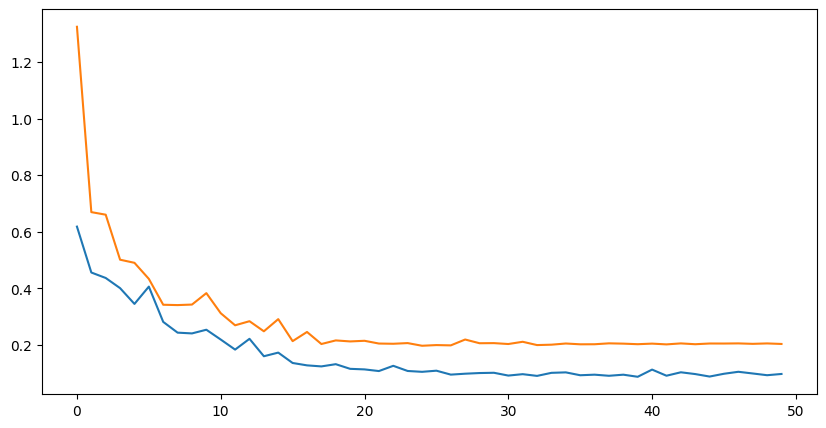

In [12]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list1)
plt.plot(val_losses)
#plt.show()

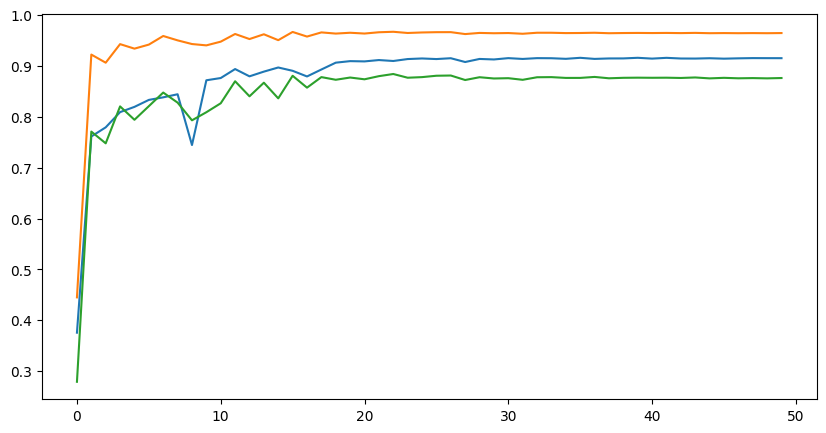

In [13]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)
plt.plot(val_accs)
plt.plot(val_mious)
#plt.show()